In [1]:
import numpy as np
import h5py

import sys
sys.path.append('../src')
from hdf_dataset import HDF3DIterator, ChunkBatchSampler

In [2]:
with h5py.File('/grid/hackathon/data_norepl/splarseers/output/embed_val.h5', 'r') as f:
    print(f['embed_val'].shape)

with h5py.File('/grid/hackathon/data_norepl/splarseers/output/embed_train.h5', 'r') as f:
    print(f['embed_train'].shape)

with h5py.File('/grid/hackathon/data_norepl/splarseers/output/embed_test.h5', 'r') as f:
    print(f['embed_test'].shape)


(58401, 5000, 32)
(210308, 5000, 32)
(12936, 5000, 32)


In [3]:
ds = HDF3DIterator('/grid/hackathon/data_norepl/splarseers/output/embed_test.h5', 'embed_test', chunk_size=500)
print(ds[0])
print(f'cache start {ds.cache_start_idx} cache end {ds.cache_end_idx}')
print(f'{ds.cached_data.shape=}')

[-14.788992    -0.13772917  -6.9167194   -7.147928    -6.5085807
  -2.4920201  -11.816504    -0.15432286 -10.758995    -1.6728089
  -8.642149    55.679256   -28.637253    -2.655271    -3.6529946
  -0.42918885  -2.3963785   -9.7070875  -13.436465    -1.0395038
   3.061552    -2.2425766    5.2509847   13.234465    53.465885
  10.902332   -13.693389   -22.551765     8.872792     0.8852031
   7.2096043    9.083712  ]
cache start 0 cache end 5000
ds.cached_data.shape=(1, 5000, 32)


In [4]:
ds = HDF3DIterator('/grid/hackathon/data_norepl/splarseers/output/embed_test.h5', 'embed_test', chunk_size=5000)
print(ds[0])
print(f'cache start {ds.cache_start_idx} cache end {ds.cache_end_idx}')
print(f'{ds.cached_data.shape=}')

[-14.788992    -0.13772917  -6.9167194   -7.147928    -6.5085807
  -2.4920201  -11.816504    -0.15432286 -10.758995    -1.6728089
  -8.642149    55.679256   -28.637253    -2.655271    -3.6529946
  -0.42918885  -2.3963785   -9.7070875  -13.436465    -1.0395038
   3.061552    -2.2425766    5.2509847   13.234465    53.465885
  10.902332   -13.693389   -22.551765     8.872792     0.8852031
   7.2096043    9.083712  ]
cache start 0 cache end 5000
ds.cached_data.shape=(1, 5000, 32)


In [5]:
ds = HDF3DIterator('/grid/hackathon/data_norepl/splarseers/output/embed_test.h5', 'embed_test', chunk_size=5001)
print(ds[0])
print(f'cache start {ds.cache_start_idx} cache end {ds.cache_end_idx}')
print(f'{ds.cached_data.shape=}')

[-14.788992    -0.13772917  -6.9167194   -7.147928    -6.5085807
  -2.4920201  -11.816504    -0.15432286 -10.758995    -1.6728089
  -8.642149    55.679256   -28.637253    -2.655271    -3.6529946
  -0.42918885  -2.3963785   -9.7070875  -13.436465    -1.0395038
   3.061552    -2.2425766    5.2509847   13.234465    53.465885
  10.902332   -13.693389   -22.551765     8.872792     0.8852031
   7.2096043    9.083712  ]
cache start 0 cache end 10000
ds.cached_data.shape=(2, 5000, 32)


In [6]:
sampler = ChunkBatchSampler(ds, 10)
for batch in sampler:
    print(batch)
    break

[20250381, 20256619, 20251181, 20255133, 20255762, 20255693, 20255817, 20255092, 20252896, 20258149]



Batch size 5:
start chunk sampler
Chunk Sampler - Mean: 0.0039s ± 0.0117s
start random sampler
Random Sampler - Mean: 1.4726s ± 1.9409s

Batch size 10:
start chunk sampler
Chunk Sampler - Mean: 0.0183s ± 0.0550s
start random sampler
Random Sampler - Mean: 2.0799s ± 2.0802s

Batch size 50:
start chunk sampler
Chunk Sampler - Mean: 0.0038s ± 0.0111s
start random sampler
Random Sampler - Mean: 7.8519s ± 2.3847s

Batch size 100:
start chunk sampler
Chunk Sampler - Mean: 0.0065s ± 0.0191s
start random sampler
Random Sampler - Mean: 13.9599s ± 2.3613s


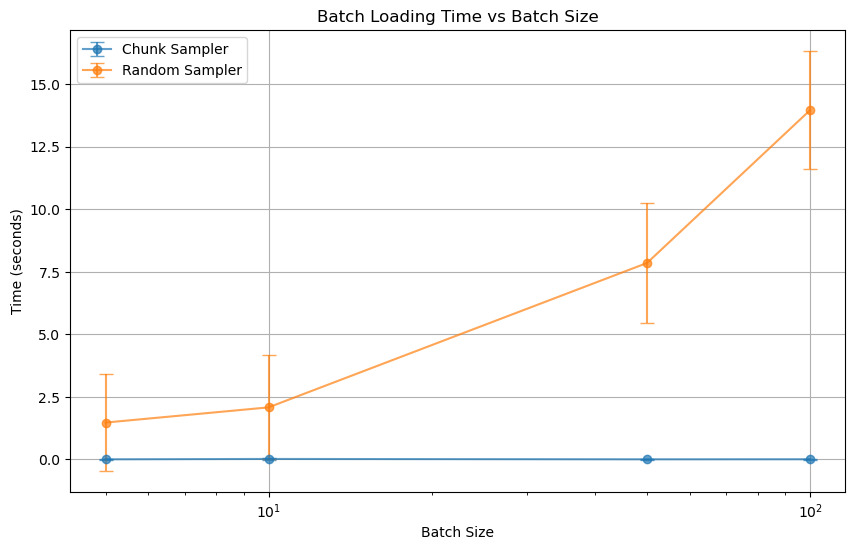

In [19]:
import time
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import RandomSampler

def measure_batch_times(ds, batch_size, n_trials=10):
    # Test with ChunkBatchSampler
    print(f"\nBatch size {batch_size}:")

    print('start chunk sampler')
    chunk_times = []
    chunk_sampler = iter(ChunkBatchSampler(ds, batch_size, shuffle=True))
    for _ in range(n_trials):
        start = time.time()
        batch = next(chunk_sampler)
        _ = ds[batch]  # Actually load the data
        chunk_times.append(time.time() - start)

    chunk_mean = np.mean(chunk_times)
    chunk_std = np.std(chunk_times)
    print(f"Chunk Sampler - Mean: {chunk_mean:.4f}s ± {chunk_std:.4f}s")
    
    # Test with random sampling
    random_times = []
    random_sampler = iter(RandomSampler(ds))
    print('start random sampler')
    for _ in range(n_trials):
        start = time.time()
        batch = [next(random_sampler) for _ in range(batch_size)]
        _ = ds[batch]  # Actually load the data
        random_times.append(time.time() - start)
    random_mean = np.mean(random_times)
    random_std = np.std(random_times)
   
    print(f"Random Sampler - Mean: {random_mean:.4f}s ± {random_std:.4f}s")
    return chunk_mean, chunk_std, random_mean, random_std

# Initialize dataset
ds = HDF3DIterator('/grid/hackathon/data_norepl/splarseers/output/embed_test.h5', 'embed_test', chunk_size=500)

# Test different batch sizes
batch_sizes = [5, 10, 50, 100]
chunk_means = []
chunk_stds = []
random_means = []
random_stds = []

for batch_size in batch_sizes:
    chunk_mean, chunk_std, random_mean, random_std = measure_batch_times(ds, batch_size)
    chunk_means.append(chunk_mean)
    chunk_stds.append(chunk_std)
    random_means.append(random_mean)
    random_stds.append(random_std)

# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(batch_sizes, chunk_means, yerr=chunk_stds, label='Chunk Sampler', 
             capsize=5, marker='o', linestyle='-', alpha=0.7)
plt.errorbar(batch_sizes, random_means, yerr=random_stds, label='Random Sampler', 
             capsize=5, marker='o', linestyle='-', alpha=0.7)
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Batch Loading Time vs Batch Size')
plt.legend()
plt.grid(True)
plt.xscale('log', base=10)
# plt.yscale('log')


In [20]:
import time
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import RandomSampler

def measure_batch_times(ds, batch_size, n_trials=10):
    # Test with ChunkBatchSampler
    print(f"\nBatch size {batch_size}:")

    print('start chunk sampler')
    chunk_times = []
    chunk_sampler = iter(ChunkBatchSampler(ds, batch_size, shuffle=True))
    for _ in range(n_trials):
        start = time.time()
        batch = next(chunk_sampler)
        _ = ds[batch]  # Actually load the data
        chunk_times.append(time.time() - start)

    chunk_mean = np.mean(chunk_times)
    chunk_std = np.std(chunk_times)
    print(f"Chunk Sampler - Mean: {chunk_mean:.4f}s ± {chunk_std:.4f}s")
    
    # Test with random sampling
    random_times = []
    random_sampler = iter(RandomSampler(ds))
    print('start random sampler')
    for _ in range(n_trials):
        start = time.time()
        batch = [next(random_sampler) for _ in range(batch_size)]
        _ = ds[batch]  # Actually load the data
        random_times.append(time.time() - start)
    random_mean = np.mean(random_times)
    random_std = np.std(random_times)
   
    print(f"Random Sampler - Mean: {random_mean:.4f}s ± {random_std:.4f}s")
    return chunk_mean, chunk_std, random_mean, random_std

# Initialize dataset
ds = HDF3DIterator('/grid/hackathon/data_norepl/splarseers/output/embed_test.h5', 'embed_test', chunk_size=500)

# Test different batch sizes
batch_sizes = [7, 10, 50, 100]
chunk_means = []
chunk_stds = []
random_means = []
random_stds = []

for batch_size in batch_sizes:
    chunk_mean, chunk_std, random_mean, random_std = measure_batch_times(ds, batch_size)
    chunk_means.append(chunk_mean)
    chunk_stds.append(chunk_std)
    random_means.append(random_mean)
    random_stds.append(random_std)

# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(batch_sizes, chunk_means, yerr=chunk_stds, label='Chunk Sampler', 
             capsize=5, marker='o', linestyle='-', alpha=0.7)
plt.errorbar(batch_sizes, random_means, yerr=random_stds, label='Random Sampler', 
             capsize=5, marker='o', linestyle='-', alpha=0.7)
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Batch Loading Time vs Batch Size')
plt.legend()
plt.grid(True)
plt.xscale('log', base=10)
# plt.yscale('log')



Batch size 7:
start chunk sampler


ValueError: Chunk length is not a multiple of the batch size

In [17]:
ds.cached_data.shape

(3, 5000, 32)

In [6]:
ds = HDF3DIterator('/grid/hackathon/data_norepl/splarseers/output/embed_train.h5', 'embed_train')
ds[0]

array([1.000000e+00, 8.335636e-09, 4.705444e-10], dtype=float32)

In [7]:
with h5py.File('/grid/hackathon/data_norepl/splarseers/output/embed_train.h5', 'r') as f:
    print(f['embed_train'].shape)


(210308, 5000, 3)


In [3]:
with h5py.File('./test.h5', 'w') as f:
    f.create_dataset('data', data=arr)



In [5]:
with HDF3DIterator('./test.h5', 'data') as hdf:
    print(hdf[0])
    print(hdf[0:10])
    print(hdf[0,0])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31]
 [ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
   50  51  52  53  54  55  56  57  58  59  60  61  62  63]
 [ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
   82  83  84  85  86  87  88  89  90  91  92  93  94  95]
 [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
  114 115 116 117 118 119 120 121 122 123 124 125 126 127]
 [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
  146 147 148 149 150 151 152 153 154 155 156 157 158 159]
 [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
  178 179 180 181 182 183 184 185 186 187 188 189 190 191]
 [192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
  210 211 212 213 214 215 216

In [6]:
with HDF3DIterator('./test.h5', 'data') as hdf:
    print(hdf[0])
    print(hdf[1])
    print(hdf[2])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63]
[64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87
 88 89 90 91 92 93 94 95]


In [12]:
with HDF3DIterator('./test.h5', 'data') as hdf:
    for i, data in enumerate(hdf):
        print(i, data)
        if i > 10:
            break

0 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
1 [32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63]
2 [64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87
 88 89 90 91 92 93 94 95]
3 [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127]
4 [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
5 [160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191]
6 [192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223]
7 [224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255]
8 [256 257 258 259 260 261 262 2

In [16]:
print('jo')

jo


In [17]:
from torch.utils.data import DataLoader

train_ds = HDF3DIterator('./test.h5', 'data')
train_ds.open()

train_dl = DataLoader(train_ds, batch_size=10, num_workers=0)

next(iter(train_dl))




tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31],
        [ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
          46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
          60,  61,  62,  63],
        [ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
          92,  93,  94,  95],
        [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
         110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
         124, 125, 126, 127],
        [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
         142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159],
        [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 1